# Simple pipeline

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import numpy as np
from structuredgraph import StructuredGraph
from structural_equation import lin_hidden_max_obs_generator, max_generator, Const, \
StructuralEquation, Linear, set_weights, Noise, NoisyLinear
import matplotlib.pyplot as plt
import torch
import random
from torch.autograd import Variable

In [2]:
n_hidden = 2
n_observations = 4

Define a simple structural equation generator

In [3]:
def my_structeq_generator(graph, index):
    
    def edge_weight_sampler(g, edges):
        return 2*np.random.binomial(1, 0.5, size=len(edges)) - 1

    function = Linear()
    set_weights(graph, graph.in_edges(index), edge_weight_sampler)

    # If a node has no parent, generate noise
    if len(list(graph.predecessors(index))) == 0:
        function = Noise()

    return StructuralEquation(graph, index, function)

Create the graph

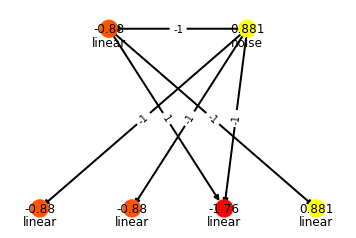

In [4]:
np.random.seed(3)
random.seed(3)
G = StructuredGraph(n_hidden=n_hidden, n_observations=n_observations,
                   structural_equation_generator=my_structeq_generator)
G.generate()
G.draw(show_values=True, show_eq=True, show_weights=True)

## Model

Define model

In [5]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [6]:
model = linearRegression(n_hidden, n_observations).double()
G.generate(10)
hidden_data, obs_data = G.get_observations(with_hidden=True)
print("shape of hidden data", hidden_data.shape)
print("shape of obs data", obs_data.shape)

shape of hidden data (10, 2)
shape of obs data (10, 4)


In [7]:
inputs = torch.tensor(hidden_data)
labels = torch.tensor(obs_data)

In [8]:
model(inputs)

tensor([[-0.3306,  0.2004,  0.7576, -0.5242],
        [-0.4026, -0.2211,  0.0244, -0.5524],
        [-0.4223, -0.3366, -0.1765, -0.5601],
        [-0.4284, -0.3723, -0.2386, -0.5625],
        [-0.4718, -0.6265, -0.6809, -0.5794],
        [-0.3622,  0.0157,  0.4363, -0.5366],
        [-0.4525, -0.5134, -0.4841, -0.5719],
        [-0.4561, -0.5348, -0.5212, -0.5733],
        [-0.4136, -0.2860, -0.0885, -0.5567],
        [-0.3403,  0.1436,  0.6589, -0.5280]], dtype=torch.float64,
       grad_fn=<AddmmBackward>)

In [9]:
model.linear.weight

Parameter containing:
tensor([[ 0.3145,  0.2712],
        [-0.4504, -0.7043],
        [ 0.2888, -0.1530],
        [ 0.7034,  0.6865]], dtype=torch.float64, requires_grad=True)

## Training model

We will plot the parameters of our linear regression along with the parameters of the ground truth linear regression

In [10]:
ground_truth_weight = np.zeros((n_observations, n_hidden))
for edge in G.graph.in_edges.data(nbunch=G.get_observation_nodes(), data='weight'):
    ground_truth_weight[edge[1]-n_hidden, edge[0]] = edge[2]

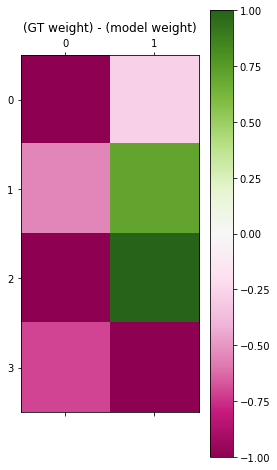

In [11]:
matrix_of_differences = ground_truth_weight - model.linear.weight.detach().numpy()
plt.matshow(matrix_of_differences, cmap="PiYG")
plt.title("(GT weight) - (model weight)")
plt.clim(vmin=-1, vmax=1)
plt.colorbar()
plt.show()

### Regular Training

In [59]:
n_batch = 500
batch_size = 16
learningRate = 0.00001 
losses = []

In [60]:
model = linearRegression(n_hidden, n_observations).double()
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

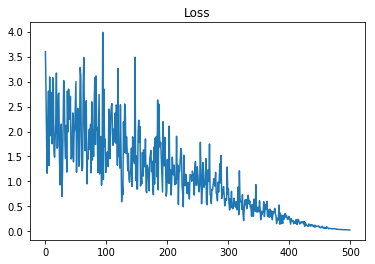

In [61]:
for batch in range(n_batch):
    # Generate data
    G.generate(batch_size)
    hidden_data, obs_data = G.get_observations(with_hidden=True)
    inputs = torch.tensor(hidden_data)
    labels = torch.tensor(obs_data)
    
    # Compute predictions
    outputs = model(inputs)
    
    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward()
    losses.append(loss.item())

    # update parameters
    optimizer.step()
    
plt.plot(losses)
plt.title("Loss")
plt.show()

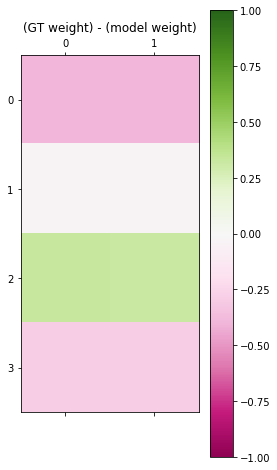

In [62]:
matrix_of_differences = ground_truth_weight - model.linear.weight.detach().numpy()
plt.matshow(matrix_of_differences, cmap="PiYG")
plt.title("(GT weight) - (model weight)")
plt.clim(vmin=-1, vmax=1)
plt.colorbar()
plt.show()

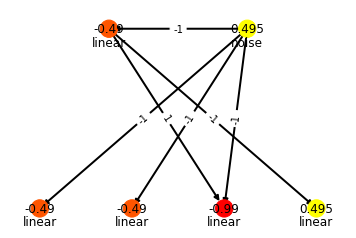

In [63]:
G.draw(show_values=True, show_eq=True, show_weights=True)

With the current example, valid solutions are:

$y_0 = - \lambda x_0 + (1- \lambda) x_1$ with $\lambda \in \mathbb{R}$

$y_1 = - \lambda x_0 + (1- \lambda) x_1$

$y_2 = -  2\lambda x_0 + 2(1- \lambda) x_1$

$y_3 =  \lambda x_0 - (1- \lambda) x_1$

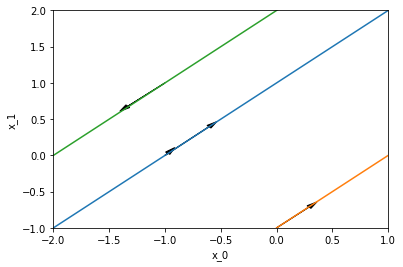

In [64]:
ax = plt.axes()
ax.set_xlim(-2, 1)
ax.set_ylim(-1, 2)
for i in range(ground_truth_weight.shape[0]):
    x = ground_truth_weight[i, 0]
    y = ground_truth_weight[i, 1]
    dx = - matrix_of_differences[i, 0]
    dy = - matrix_of_differences[i, 1]
    ax.arrow(x, y, dx, dy, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.plot([-10, 10], [-9, 11])
plt.plot([0, 1], [-1, 0])
plt.plot([-10, 10], [-8, 12])
plt.xlabel("x_0")
plt.ylabel("x_1")
plt.show()

### Training in multiple environments with alternated interventions

In [48]:
n_batch = 200
batch_size = 16
learningRate = 0.0001 
losses = []

In [49]:
model = linearRegression(n_hidden, n_observations).double()
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

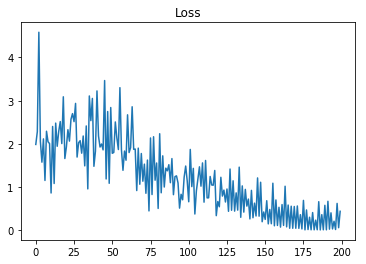

In [50]:
for batch in range(n_batch):
    # Generate data
    if batch%2 == 1:
        G.set_intervention(node=1, function=Noise)
    G.generate(batch_size)
    hidden_data, obs_data = G.get_observations(with_hidden=True)
    inputs = torch.tensor(hidden_data)
    labels = torch.tensor(obs_data)
    G.reset_intervention()
    
    # Compute predictions
    outputs = model(inputs)
    
    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward()
    losses.append(loss.item())

    # update parameters
    optimizer.step()
    
plt.plot(losses)
plt.title("Loss")
plt.show()

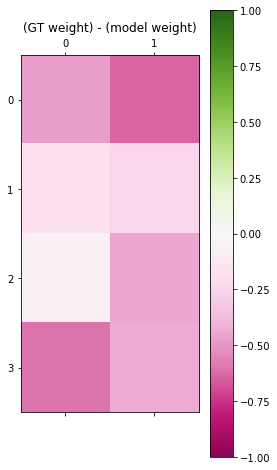

In [51]:
matrix_of_differences = ground_truth_weight - model.linear.weight.detach().numpy()
plt.matshow(matrix_of_differences, cmap="PiYG")
plt.title("(GT weight) - (model weight)")
plt.clim(vmin=-1, vmax=1)
plt.colorbar()
plt.show()

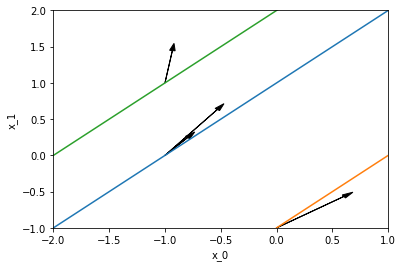

In [52]:
ax = plt.axes()
ax.set_xlim(-2, 1)
ax.set_ylim(-1, 2)
for i in range(ground_truth_weight.shape[0]):
    x = ground_truth_weight[i, 0]
    y = ground_truth_weight[i, 1]
    dx = - matrix_of_differences[i, 0]
    dy = - matrix_of_differences[i, 1]
    ax.arrow(x, y, dx, dy, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.plot([-10, 10], [-9, 11])
plt.plot([0, 1], [-1, 0])
plt.plot([-10, 10], [-8, 12])
plt.xlabel("x_0")
plt.ylabel("x_1")
plt.show()

### Training in multiple environments shuffled

In [53]:
n_batch = 200
batch_size = 16
learningRate = 0.0001 
losses = []

In [54]:
model = linearRegression(n_hidden, n_observations).double()
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

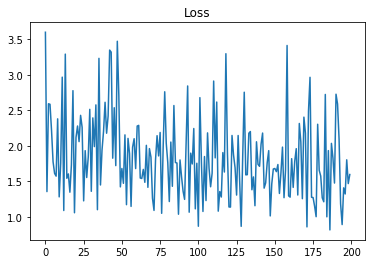

In [55]:
for batch in range(n_batch):
    # Generate data with both environments (one after the other)
    G.set_intervention(node=1, function=Noise)
    G.generate(int(batch_size/2))
    hidden_data_1, obs_data_1 = G.get_observations(with_hidden=True)
    G.reset_intervention()
    G.generate(int(batch_size/2))
    hidden_data_2, obs_data_2 = G.get_observations(with_hidden=True)
    hidden_data = np.concatenate((hidden_data_1, hidden_data_2), axis=0)
    obs_data = np.concatenate((obs_data_1, obs_data_2), axis=0)
    
    # Shuffle examples within batch
    np.random.shuffle(hidden_data)
    np.random.shuffle(obs_data)

    inputs = torch.tensor(hidden_data)
    labels = torch.tensor(obs_data)
    
    # Compute predictions
    outputs = model(inputs)
    
    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward()
    losses.append(loss.item())

    # update parameters
    optimizer.step()
    
plt.plot(losses)
plt.title("Loss")
plt.show()

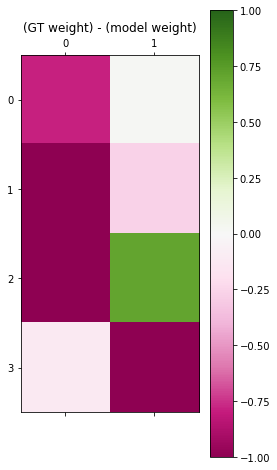

In [56]:
matrix_of_differences = ground_truth_weight - model.linear.weight.detach().numpy()
plt.matshow(matrix_of_differences, cmap="PiYG")
plt.title("(GT weight) - (model weight)")
plt.clim(vmin=-1, vmax=1)
plt.colorbar()
plt.show()

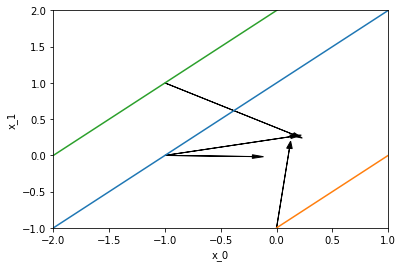

In [58]:
ax = plt.axes()
ax.set_xlim(-2, 1)
ax.set_ylim(-1, 2)
for i in range(ground_truth_weight.shape[0]):
    x = ground_truth_weight[i, 0]
    y = ground_truth_weight[i, 1]
    dx = - matrix_of_differences[i, 0]
    dy = - matrix_of_differences[i, 1]
    ax.arrow(x, y, dx, dy, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.plot([-10, 10], [-9, 11])
plt.plot([0, 1], [-1, 0])
plt.plot([-10, 10], [-8, 12])
plt.xlabel("x_0")
plt.ylabel("x_1")
plt.show()